# Lithium Analysis: Data Loading and Exploration

This notebook analyzes the relationship between lithium levels in water and mortality rates for Alzheimer's Disease, Non-AD Dementia, and Parkinson's Disease.

## Setup and Imports


In [ ]:
# !pip install itables
!pip install -q jupyter_bokeh
!pip install -q panel

In [ ]:
import gdown
import duckdb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itables import show


## Data Loading


In [ ]:
# Download the database from Google Drive
file_id = '1XQQ84kyaQ3ehI5FL3XSHxy6ype7qGzGD'
url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, 'data.duckdb', quiet=False)

# Connect to the database
conn = duckdb.connect('data.duckdb')

# Load each table as a dataframe
ad_df = conn.execute("select * from Underlying_Cause_of_Death_1999_2020_AD").df()
parkinsons_df = conn.execute("select * from Underlying_Cause_of_Death_1999_2020_Parkinsons").df()
non_ad_df = conn.execute("select * from Underlying_Cause_of_Death_1999_2020_non_AD").df()
lithium_df = conn.execute("select * from lithium_aggregated_by_county").df()

print(f"AD Deaths: {ad_df.shape[0]:,} rows × {ad_df.shape[1]} columns")
print(f"Parkinsons Deaths: {parkinsons_df.shape[0]:,} rows × {parkinsons_df.shape[1]} columns")
print(f"Non-AD Deaths: {non_ad_df.shape[0]:,} rows × {non_ad_df.shape[1]} columns")
print(f"Lithium by County: {lithium_df.shape[0]:,} rows × {lithium_df.shape[1]} columns")


Downloading...
From: https://drive.google.com/uc?id=1XQQ84kyaQ3ehI5FL3XSHxy6ype7qGzGD
To: /content/data.duckdb
100%|██████████| 1.32M/1.32M [00:00<00:00, 41.3MB/s]

AD Deaths: 3,050 rows × 5 columns
Parkinsons Deaths: 2,764 rows × 5 columns
Non-AD Deaths: 1,863 rows × 5 columns
Lithium by County: 3,109 rows × 35 columns


### Preview Data

In [ ]:
import panel as pn
pn.extension('tabulator')
pn.Tabs(
    ('Lithium', pn.widgets.Tabulator(lithium_df, page_size=50, pagination='remote', header_filters=True, sorters=[{'field': col, 'dir': 'asc'} for col in lithium_df.columns])),
    ('Parkinsons', pn.widgets.Tabulator(parkinsons_df, page_size=50, pagination='remote', header_filters=True, sorters=[{'field': col, 'dir': 'asc'} for col in parkinsons_df.columns])),
    ('Non-AD', pn.widgets.Tabulator(non_ad_df, page_size=50, pagination='remote', header_filters=True, sorters=[{'field': col, 'dir': 'asc'} for col in non_ad_df.columns])),
    ('AD', pn.widgets.Tabulator(ad_df, page_size=50, pagination='remote', header_filters=True, sorters=[{'field': col, 'dir': 'asc'} for col in ad_df.columns]))
)

Tabs
    [0] Tabulator(header_filters=True, page_size=50, pagination='remote', sorters=[{'field': 'county_code', ...], value=      county_code  ...)
    [1] Tabulator(header_filters=True, page_size=50, pagination='remote', sorters=[{'field': 'County', ...], value=                     Count...)
    [2] Tabulator(header_filters=True, page_size=50, pagination='remote', sorters=[{'field': 'County', ...], value=                   County ...)
    [3] Tabulator(header_filters=True, page_size=50, pagination='remote', sorters=[{'field': 'County', ...], value=                     Count...)

## Data Prep

In [ ]:
# Clean death data by removing Notes and Deaths columns
ad_deaths_df = ad_df.drop(['Deaths'], axis=1)
parkinsons_deaths_df = parkinsons_df.drop(['Deaths'], axis=1)
non_ad_deaths_df = non_ad_df.drop(['Deaths'], axis=1)


In [ ]:
# Clean lithium data by removing unnecessary columns
columns_to_drop = [
    'total_grid_cells',
    'domestic_cells',
    'public_cells',
    'cells_cat_1', 'cells_cat_2', 'cells_cat_3', 'cells_cat_4',
    'dom_cells_cat_1', 'dom_cells_cat_2', 'dom_cells_cat_3', 'dom_cells_cat_4',
    'pub_cells_cat_1', 'pub_cells_cat_2', 'pub_cells_cat_3', 'pub_cells_cat_4',
    'pct_cat_1', 'pct_cat_2', 'pct_cat_3', 'pct_cat_4',
    'dom_pct_cat_1', 'dom_pct_cat_2', 'dom_pct_cat_3', 'dom_pct_cat_4',
    'pub_pct_cat_1', 'pub_pct_cat_2', 'pub_pct_cat_3', 'pub_pct_cat_4'
]

lithium_clean_df = lithium_df.drop(columns=columns_to_drop)


In [ ]:
# Extract key lithium variables for analysis
lithium_key_df = lithium_clean_df[['county_code', 'county_name', 'dominant_category']]


## Exploratory Data Analysis


### Lithium Data: Correlation Analysis


In [ ]:
# Select only numeric columns for correlation, excluding 'county_code'
numeric_cols = lithium_clean_df.select_dtypes(include=["number"]).drop('county_code', axis=1)

# Compute correlation matrix
correlation_matrix = numeric_cols.corr()

# Display correlation matrix
correlation_matrix.style.background_gradient(cmap='coolwarm')


,avg_category,dominant_category,dom_avg_category,dom_dominant_category,pub_avg_category,pub_dominant_category
avg_category,1.000000,0.945995,0.994714,0.941537,0.994611,0.939921
dominant_category,0.945995,1.000000,0.942991,0.967046,0.938900,0.961095
dom_avg_category,0.994714,0.942991,1.000000,0.949454,0.978732,0.923963
dom_dominant_category,0.941537,0.967046,0.949454,1.000000,0.923495,0.929805
pub_avg_category,0.994611,0.938900,0.978732,0.923495,1.000000,0.945986
pub_dominant_category,0.939921,0.961095,0.923963,0.929805,0.945986,1.000000


### Lithium Data: Distribution of Dominant Category


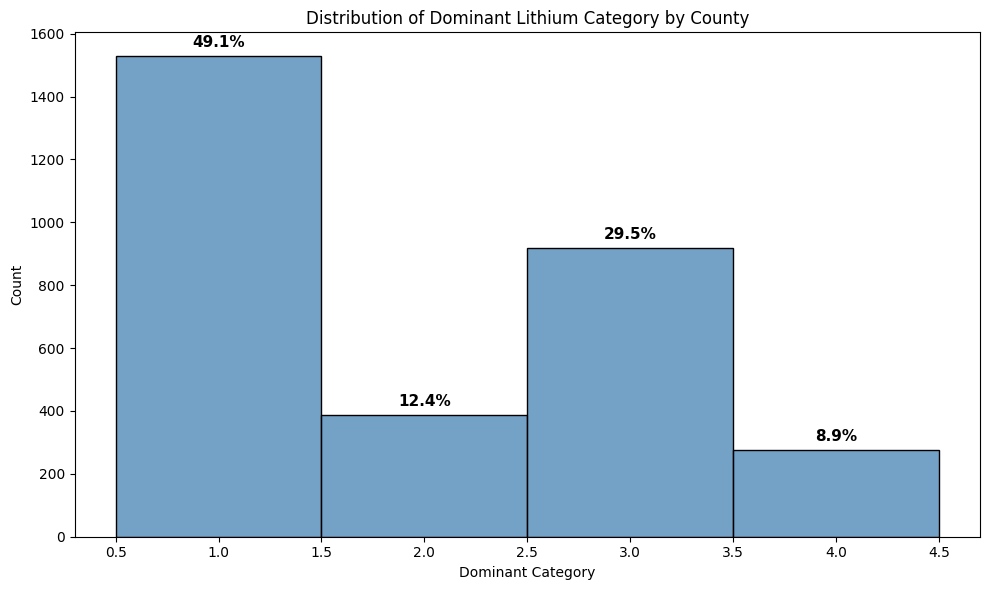

In [ ]:
# Calculate counts and percentages
category_counts = lithium_key_df['dominant_category'].value_counts().sort_index()
total = category_counts.sum()
percentages = (category_counts / total * 100).round(1)

# Create histogram
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=lithium_key_df, x="dominant_category", discrete=True, kde=False, color="steelblue", ax=ax)

# Add percentage labels on top of each bar
for i, (count, pct) in enumerate(zip(category_counts, percentages)):
    ax.text(category_counts.index[i], count + 20, f'{pct}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title("Distribution of Dominant Lithium Category by County")
plt.xlabel("Dominant Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### Death Rate Distributions


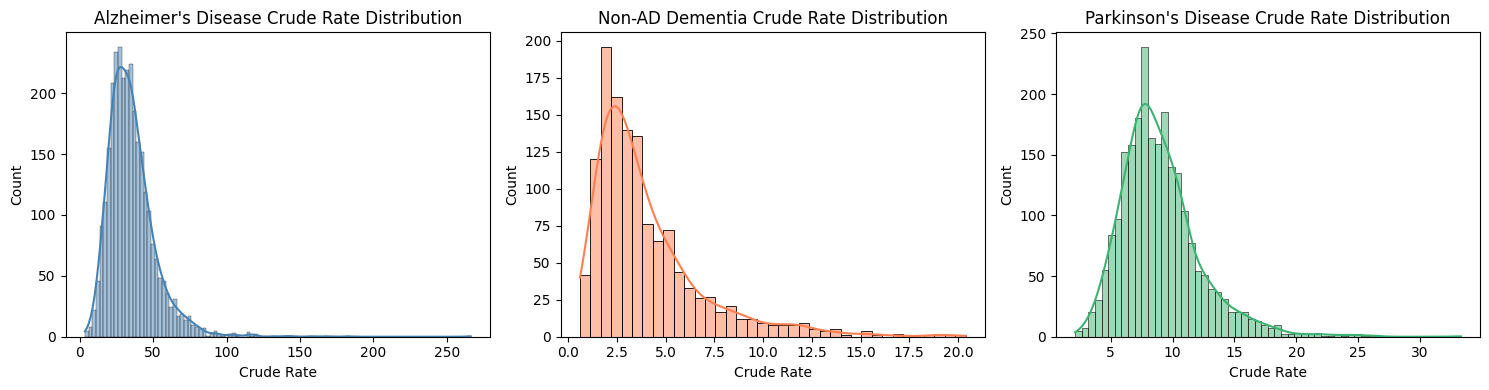

In [ ]:
# Prepare data for visualization
ad_data = ad_deaths_df.copy()
ad_data["Crude_Rate"] = pd.to_numeric(ad_data["Crude_Rate"], errors="coerce")

non_ad_data = non_ad_deaths_df.copy()
non_ad_data["Crude_Rate"] = pd.to_numeric(non_ad_data["Crude_Rate"], errors="coerce")

parkinsons_data = parkinsons_deaths_df.copy()
parkinsons_data["Crude_Rate"] = pd.to_numeric(parkinsons_data["Crude_Rate"], errors="coerce")

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# AD histogram
sns.histplot(data=ad_data, x="Crude_Rate", kde=True, ax=axes[0], color="steelblue")
axes[0].set_title("Alzheimer's Disease Crude Rate Distribution")
axes[0].set_xlabel("Crude Rate")
axes[0].set_ylabel("Count")

# Non-AD histogram
sns.histplot(data=non_ad_data, x="Crude_Rate", kde=True, ax=axes[1], color="coral")
axes[1].set_title("Non-AD Dementia Crude Rate Distribution")
axes[1].set_xlabel("Crude Rate")
axes[1].set_ylabel("Count")

# Parkinson's histogram
sns.histplot(data=parkinsons_data, x="Crude_Rate", kde=True, ax=axes[2], color="mediumseagreen")
axes[2].set_title("Parkinson's Disease Crude Rate Distribution")
axes[2].set_xlabel("Crude Rate")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()


## Data Merging: Lithium and Death Rates


In [ ]:
# Merge lithium data with death rate data for each disease type
ad_joined = lithium_key_df.merge(ad_data, left_on='county_code', right_on='County_Code', how='left')
ad_joined = ad_joined.drop(columns=['County_Code', 'County'])

non_ad_joined = lithium_key_df.merge(non_ad_data, left_on='county_code', right_on='County_Code', how='left')
non_ad_joined = non_ad_joined.drop(columns=['County_Code', 'County'])

parkinsons_joined = lithium_key_df.merge(parkinsons_data, left_on='county_code', right_on='County_Code', how='left')
parkinsons_joined = parkinsons_joined.drop(columns=['County_Code', 'County'])


## Visual Analysis: Lithium Category vs. Death Rates


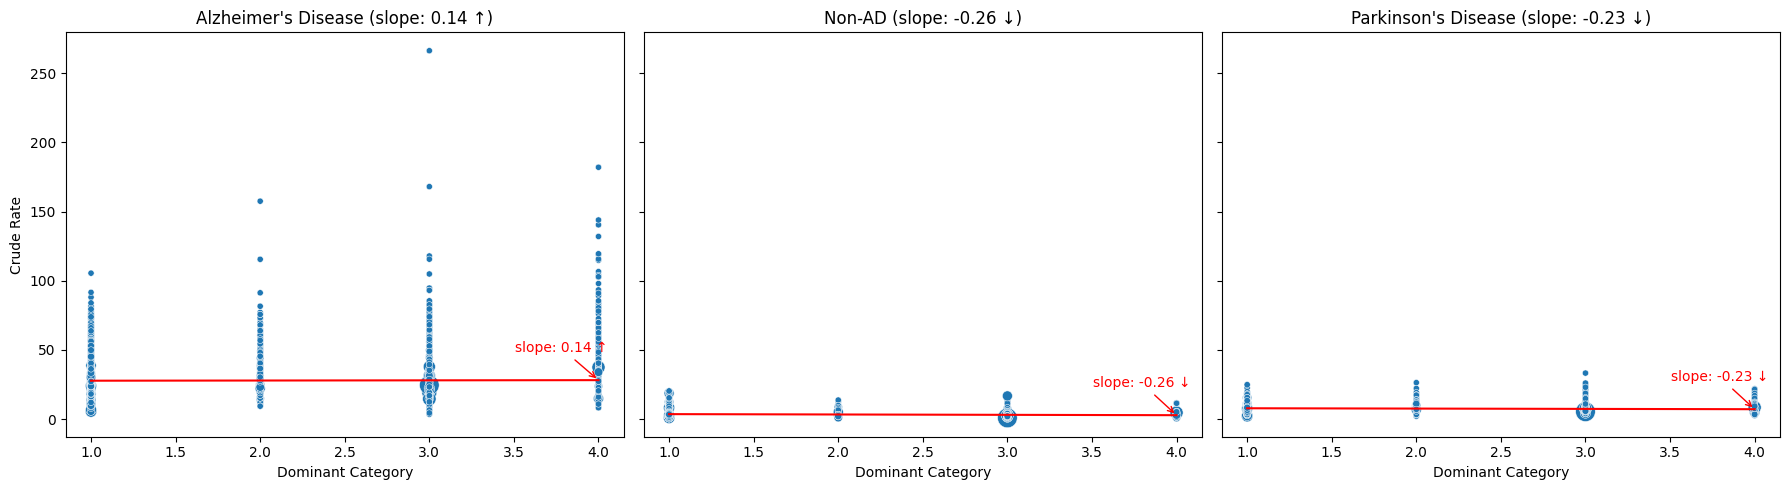

In [ ]:
# Convert Crude_Rate to numeric, coercing errors to NaN
ad_joined["Crude_Rate"] = pd.to_numeric(ad_joined["Crude_Rate"], errors="coerce")
non_ad_joined["Crude_Rate"] = pd.to_numeric(non_ad_joined["Crude_Rate"], errors="coerce")
parkinsons_joined["Crude_Rate"] = pd.to_numeric(parkinsons_joined["Crude_Rate"], errors="coerce")

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
datasets = [ad_joined, non_ad_joined, parkinsons_joined]
titles = ["Alzheimer's Disease", "Non-AD", "Parkinson's Disease"]

for ax, data, title in zip(axes, datasets, titles):
    # Drop rows where either axis is NaN
    plot_data = data.dropna(subset=["Crude_Rate", "dominant_category", "Population"])
    # Size points by population (area proportional)
    sns.scatterplot(data=plot_data, x="dominant_category", y="Crude_Rate", ax=ax,
                    size="Population", sizes=(20, 200), legend=False)
    # Fit trend using WLS (weight=Population)
    X = plot_data["dominant_category"]
    y = plot_data["Crude_Rate"]
    weights = plot_data["Population"]
    X_const = sm.add_constant(X)
    wls_model = sm.WLS(y, X_const, weights=weights)
    results = wls_model.fit()
    x_range = np.linspace(X.min(), X.max(), 100)
    y_pred = results.predict(sm.add_constant(x_range))
    ax.plot(x_range, y_pred, color="red")
    # Label the trend line with slope value and direction
    slope = results.params.iloc[1]
    slope_direction = "↑" if slope > 0 else ("↓" if slope < 0 else "→")
    ax.annotate(f"slope: {slope:.2f} {slope_direction}",
                xy=(x_range[-1], y_pred[-1]),
                xytext=(-60, 20), textcoords='offset points',
                fontsize=10, color="red",
                arrowprops=dict(arrowstyle="->", color='red'))
    ax.set_title(f"{title} (slope: {slope:.2f} {slope_direction})")
    ax.set_xlabel("Dominant Category")
    ax.set_ylabel("Crude Rate")

plt.tight_layout()
plt.show()


## Statistical Analysis: Weighted Least Squares Regression


### Alzheimer's Disease Regression


In [ ]:
# Prepare data
ad_reg = ad_joined.copy()
ad_reg["Crude_Rate"] = pd.to_numeric(ad_reg["Crude_Rate"], errors="coerce")
ad_reg = ad_reg.dropna(subset=["Crude_Rate", "dominant_category", "Population"])

# Set up weighted least squares regression
X = ad_reg["dominant_category"]
y = ad_reg["Crude_Rate"]
weights = ad_reg["Population"]

# Add constant and fit model
X_const = sm.add_constant(X)
wls_model = sm.WLS(y, X_const, weights=weights)
wls_results = wls_model.fit()

# Display results
print(wls_results.summary())


                            WLS Regression Results                            
Dep. Variable:             Crude_Rate   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4311
Date:                Thu, 18 Dec 2025   Prob (F-statistic):              0.511
Time:                        14:05:07   Log-Likelihood:                -12902.
No. Observations:                2925   AIC:                         2.581e+04
Df Residuals:                    2923   BIC:                         2.582e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                27.6563      0.44

### Non-AD Dementia Regression


In [ ]:
# Prepare data
non_ad_reg = non_ad_joined.copy()
non_ad_reg["Crude_Rate"] = pd.to_numeric(non_ad_reg["Crude_Rate"], errors="coerce")
non_ad_reg = non_ad_reg.dropna(subset=["Crude_Rate", "dominant_category", "Population"])

# Set up weighted least squares regression
X = non_ad_reg["dominant_category"]
y = non_ad_reg["Crude_Rate"]
weights = non_ad_reg["Population"]

# Add constant and fit model
X_const = sm.add_constant(X)
wls_model = sm.WLS(y, X_const, weights=weights)
wls_results = wls_model.fit()

# Display results
print(wls_results.summary())


                            WLS Regression Results                            
Dep. Variable:             Crude_Rate   R-squared:                       0.009
Model:                            WLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     10.85
Date:                Thu, 18 Dec 2025   Prob (F-statistic):            0.00102
Time:                        14:05:07   Log-Likelihood:                -3556.5
No. Observations:                1256   AIC:                             7117.
Df Residuals:                    1254   BIC:                             7127.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.9015      0.16

### Parkinson's Disease Regression


In [ ]:
# Prepare data
parkinsons_reg = parkinsons_joined.copy()
parkinsons_reg["Crude_Rate"] = pd.to_numeric(parkinsons_reg["Crude_Rate"], errors="coerce")
parkinsons_reg = parkinsons_reg.dropna(subset=["Crude_Rate", "dominant_category", "Population"])

# Set up weighted least squares regression
X = parkinsons_reg["dominant_category"]
y = parkinsons_reg["Crude_Rate"]
weights = parkinsons_reg["Population"]

# Add constant and fit model
X_const = sm.add_constant(X)
wls_model = sm.WLS(y, X_const, weights=weights)
wls_results = wls_model.fit()

# Display results
print(wls_results.summary())


                            WLS Regression Results                            
Dep. Variable:             Crude_Rate   R-squared:                       0.008
Model:                            WLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     19.50
Date:                Thu, 18 Dec 2025   Prob (F-statistic):           1.05e-05
Time:                        14:05:07   Log-Likelihood:                -6565.0
No. Observations:                2328   AIC:                         1.313e+04
Df Residuals:                    2326   BIC:                         1.315e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 8.1087      0.11